# **Scrap Images from Bing**
Here I've tried to scrap 500 images with keyword *Waterfall* and 500 images with keyword *Famous Abstract Art* from **Bing** but got less than 500 images for both of these categories.

In [0]:
!pip install icrawler==0.6.2    #Install icrawler
%rm -rf ./data    # if directory ./data exists then delete it

from icrawler.builtin import BingImageCrawler

# Download Images with keyword "waterfall"
bing_crawler = BingImageCrawler(storage = {'root_dir': './data/waterfall/waterfall/'})
bing_crawler.crawl(keyword='waterfall', max_num=500)

# Download Images with keyword "famous abstract art"
bing_crawler = BingImageCrawler(storage = {'root_dir': './data/abstract_art/abstract_art/'})
bing_crawler.crawl(keyword='famous abstract art', max_num=500)

In [4]:
# Load images from directory
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_generator = ImageDataGenerator(rescale=1./255)
abstract_art_data_gen = image_generator.flow_from_directory(directory='./data/abstract_art',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH))

waterfall_data_gen = image_generator.flow_from_directory(directory='./data/waterfall',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 20 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


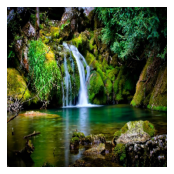

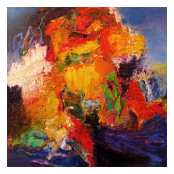

In [7]:
# Visualise Images
import matplotlib.pyplot as plt

def show_batch(image):
  plt.figure(figsize=(10,10))
  for n in range(1):
      ax = plt.subplot(3,3,n+1)
      plt.imshow(image[0])
      plt.axis('off')

image_batch1, _ = next(waterfall_data_gen)
image_batch2, _ = next(abstract_art_data_gen)
show_batch(image_batch1)
show_batch(image_batch2)

# Cycle GAN model Tensorflow
Here I'e used the [Cycle GAN model from Tensorflow official website](https://www.tensorflow.org/tutorials/generative/cyclegan) with some changes to make it compatible with **Keras ImageDataGenerator**.

In [8]:
# Install tensorflow_examples
!pip install -q git+https://github.com/tensorflow/examples.git
# Import necessary packages
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import os
import time
from IPython.display import clear_output
import numpy as np
import glob
import pathlib

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Some important patrameters
BUFFER_SIZE = 1000
EPOCHS = 50
IMG_WIDTH = 256
IMG_HEIGHT = 256
num_images = 456    # Number of Waterfall Images
OUTPUT_CHANNELS = 3

# Generators
generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# Discriminators
discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

# Generator Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Discriminator Optimizers
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Here I've saved checkpoints to my Google drive so that I can restore them later
checkpoint_path = './drive/My Drive/checkpoints/train'

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

Latest checkpoint restored!!


As I've previously trained the model so last checkpoint have been restored. So I've skipped the Training Process.

In [0]:
# Train model
sample_waterfall, _ = next(waterfall_data_gen)
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for _ in range(num_images):
    image_x, _= next(waterfall_data_gen)
    image_y, _= next(abstract_art_data_gen)
    image_x = tf.convert_to_tensor(image_x)
    image_y = tf.convert_to_tensor(image_y)
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sample_waterfall)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

# Now generate realistic artworks
Now scrap some images, pass those images to the model and save the generated artworks.

In [0]:
count=0
%rm -rf './drive/My Drive/Cycle-GAN Artworks/'
%mkdir './drive/My Drive/Cycle-GAN Artworks/'
def predict_and_display(model, data_gen, count):
  for i in range(count):
     pred = model(next(data_gen))
     tf.keras.preprocessing.image.save_img('./drive/My Drive/Cycle-GAN Artworks/'+str(count)+'.jpeg', pred[0])
     count += 1

Scrap images

In [10]:
bing_crawler = BingImageCrawler(storage = {'root_dir': './data/forest/forest/'})
bing_crawler.crawl(keyword='forest', max_num=20)

bing_crawler = BingImageCrawler(storage = {'root_dir': './data/nature_scenes/nature_scenes/'})
bing_crawler.crawl(keyword='nature scenes', max_num=100)

2020-04-01 16:08:45,902 - INFO - icrawler.crawler - start crawling...
2020-04-01 16:08:45,903 - INFO - icrawler.crawler - starting 1 feeder threads...
2020-04-01 16:08:45,907 - INFO - feeder - thread feeder-001 exit
2020-04-01 16:08:45,907 - INFO - icrawler.crawler - starting 1 parser threads...
2020-04-01 16:08:45,914 - INFO - icrawler.crawler - starting 1 downloader threads...
2020-04-01 16:08:46,399 - INFO - parser - parsing result page https://www.bing.com/images/async?q=forest&first=0
2020-04-01 16:08:46,439 - INFO - downloader - image #1	http://i.ytimg.com/vi/oHLIyot2ArA/maxresdefault.jpg
2020-04-01 16:08:46,468 - INFO - downloader - image #2	https://i.ytimg.com/vi/OtP8wicpJFk/maxresdefault.jpg
2020-04-01 16:08:49,206 - INFO - downloader - image #3	https://upload.wikimedia.org/wikipedia/commons/8/8c/Creek_and_old-growth_forest-Larch_Mountain.jpg
2020-04-01 16:08:53,514 - INFO - downloader - image #4	https://news.ufl.edu/media/newsufledu/images/2018/03/Climate-change-forests-squar

Load images from directory

In [11]:
forest_data_gen = image_generator.flow_from_directory(directory='./data/forest',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH))

nature_data_gen = image_generator.flow_from_directory(directory='./data/nature_scenes',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 20 images belonging to 1 classes.
Found 76 images belonging to 1 classes.


Generate Artworks

In [0]:
predict_and_display(generator_g, forest_data_gen, 20)
predict_and_display(generator_g, waterfall_data_gen, 20)
predict_and_display(generator_g, nature_data_gen, 76)

In [18]:
!ls -l './drive/My Drive/Cycle-GAN Artworks/'

total 1515
-rw------- 1 root root 14095 Apr  1 16:16 100.jpeg
-rw------- 1 root root 12485 Apr  1 16:16 101.jpeg
-rw------- 1 root root 14060 Apr  1 16:16 102.jpeg
-rw------- 1 root root 10282 Apr  1 16:16 103.jpeg
-rw------- 1 root root 16903 Apr  1 16:16 104.jpeg
-rw------- 1 root root 17221 Apr  1 16:16 105.jpeg
-rw------- 1 root root 13043 Apr  1 16:16 106.jpeg
-rw------- 1 root root 19958 Apr  1 16:16 107.jpeg
-rw------- 1 root root 17824 Apr  1 16:16 108.jpeg
-rw------- 1 root root 13075 Apr  1 16:16 109.jpeg
-rw------- 1 root root 14370 Apr  1 16:16 110.jpeg
-rw------- 1 root root 18855 Apr  1 16:16 111.jpeg
-rw------- 1 root root 15191 Apr  1 16:16 112.jpeg
-rw------- 1 root root 19437 Apr  1 16:16 113.jpeg
-rw------- 1 root root 14477 Apr  1 16:16 114.jpeg
-rw------- 1 root root 19210 Apr  1 16:16 115.jpeg
-rw------- 1 root root 13377 Apr  1 16:16 116.jpeg
-rw------- 1 root root 13271 Apr  1 16:16 117.jpeg
-rw------- 1 root root 10989 Apr  1 16:16 118.jpeg
-rw------- 1 root ro